In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
# from xgboost import XGBClassifier
import xgboost as xgb
from tqdm import tqdm


In [62]:
df = pd.read_csv("./data/lending_club_2020_train.csv")

df = df.drop(columns=["id",
                      "url",
                      "title",
                      "application_type",
                      "next_pymnt_d",
                      "policy_code",
                      "delinq_amnt",
                      "hardship_flag"])

grade = np.array(df["grade"])
sub_grade = np.array(df["sub_grade"])

encoder = LabelEncoder()
grade_encoded = encoder.fit_transform(grade)
sub_grade_encoded = encoder.fit_transform(sub_grade)

df["grade"] = grade_encoded
df["sub_grade"] = sub_grade_encoded

# 50% 이상 결측치를 가지는 칼럼 drop
df = df.loc[:, (df.isnull().mean() < 0.5) | (df.columns == "loan_status")]
df["int_rate"] = df["int_rate"].str.rstrip("%").astype(float) / 100

# fico_range_low
# data cleansing. add avg fico score column 
insert_loc = df.columns.get_loc('fico_range_low')
df.insert(insert_loc, 'fico_avg', (df['fico_range_low'] + df['fico_range_high']) / 2)

# emp_length
# 2 way of emp_length mapping.
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 0~10
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 1~11. 무직과 고용상태를 구분하기 위함
label_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(label_mapping)
df['emp_length'] = df['emp_length'].fillna(-1)

# term
# categorical variable Labeling
label_mapping = {
    ' 36 months': 36,
    ' 60 months': 60
}

df['term'] = df['term'].map(label_mapping)

# mths_since_last_record
# 마지막 파산 기록 이후 경과된 개월 수
# 이거 유용한 정보인거 같긴 한데, 한국어 번역에 문제가 있는 것같다. 영어 원문에 public record라고 써있는데, public record는 파산을 포함한 공적 기록을 의미한다. 따라서 꼭 파산이 아닐 수도 있음.
# https://credit.org/blogs/blog-posts/understanding-your-public-record-information 해당 링크에 따르면, 판결 등의 정보도 public record에 포함된다.
# 일단 drop

# revol_util
# follow paper (Machine learning and artificial neural networks to construct P2P lending credit-scoring model: A case using Lending Club data), form change percentage form to decimal form
# 결측치는 평균값으로 채워넣는다
df["revol_util"] = df["revol_util"].str.rstrip("%").astype(float) / 100
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

# tot_coll_amt
# 총 채권 추심 금액
# 결측값만 처리
df["tot_coll_amt"] = df["tot_coll_amt"].fillna(0)

# tot_cur_bal
# 모든 계좌 현재 잔액 합계
# 결측값은 중앙값으로
df["tot_cur_bal"] = df["tot_cur_bal"].fillna(df["tot_cur_bal"].median())

# total_rev_hi_lim
# 리볼빙 총 한도
# 결측값은 중앙값으로
df["total_rev_hi_lim"] = df["total_rev_hi_lim"].fillna(df["total_rev_hi_lim"].median())

# acc_open_past_24mths
# 최근 24개월 동안 개설된 신용거래 건수
# 결측값은 중앙값으로
df["acc_open_past_24mths"] = df["acc_open_past_24mths"].fillna(df["acc_open_past_24mths"].median())

# avg_cur_bal
# 모든 계좌의 평균 현재 잔액
# 결측값은 중앙값으로
df["avg_cur_bal"] = df["avg_cur_bal"].fillna(df["avg_cur_bal"].median())

# bc_open_to_buy
# 리볼빙 은행카드 사용 가능 한도
# 결측값은 중앙값으로
df["bc_open_to_buy"] = df["bc_open_to_buy"].fillna(df["bc_open_to_buy"].median())

# bc_util
# 은행카드 한도 대비 잔액 비율
# 결측값은 평균값으로
df['bc_util'] = df['bc_util'] / 100.0
df['bc_util'] = df['bc_util'].fillna(df['bc_util'].mean())

# dti
# 백분율 정규화
df['dti'] = df['dti'] / 100.0

# mort_acc
# 주택담보대출 계좌 수
# 결측값은 중앙값으로
df["mort_acc"] = df["mort_acc"].fillna(df["mort_acc"].median())

# num_accts_ever_120_pd
# 120일 이상 연체 경험 계좌 수
# 결측값은 중앙값으로
df["num_accts_ever_120_pd"] = df["num_accts_ever_120_pd"].fillna(df["num_accts_ever_120_pd"].median())

# num_actv_bc_tl
# num_actv_rev_tl
# num_bc_sats
# num_bc_tl
# num_il_tl
# num_op_rev_tl
# num_rev_accts
# num_rev_tl_bal_gt_0
# num_sats
# 다 현재 계좌 수에 관련된 칼럼. 나중에 보고 좀 합쳐야할듯
# 결측값은 중앙값으로
cols = [
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats'
]

df[cols] = df[cols].fillna(df[cols].median())

# num_tl_90g_dpd_24m : 최근 24개월 90일 이상 연체 계좌 수
# num_tl_op_past_12m : 최근 12개월 개설 계좌 수
# tot_hi_cred_lim : 총 최고 신용 한도
# total_bal_ex_mort : 주택담보 제외 총 잔액
# total_bc_limit : 은행카드 총 한도
# total_il_high_credit_limit : 할부 계좌 총 한도
# 결측값은 중앙값으로
cols = [
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'tot_hi_cred_lim',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit'
]

df[cols] = df[cols].fillna(df[cols].median())

# pct_tl_nvr_dlq : 연체 경험 없는 계좌 비율
# percent_bc_gt_75 : 한도 75% 초과 은행카드 계좌 비율
# 결측값은 평균으로
cols = ['pct_tl_nvr_dlq', 'percent_bc_gt_75']

df[cols] = df[cols].fillna(df[cols].mean())

# loan_status : 부도 여부, 타겟 변수
# 칼럼 값이 "Fully Paid"가 아닌 값들은 다 default로 판별
# non-default = 0, default = 1
# 'Fully Paid'와 'Charged Off'가 아닌 행 제거
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'] = np.where(df['loan_status'] == 'Fully Paid', 0, 1)

# drop columns
'''
모델링을 위해 필요없어보이는 칼럼을 삭제. 추후에 재검토를 통해 살려서 다시 쓸 수도 있음
zip_code : 알아보니 zip_code 앞 3자리로는 state + city까지 알 수 있던데, 일단 addr_state에서 state는 알 수 있으니 탈락
fico_range_low : fico_range_high와 평균내어 fico_avg라는 파생변수로 만듬
emp_title : 직업이 labeling하기 힘들 정도로 다양하기도 하고 근속 연수와 소득이 더 직관적인 데이터라고 생각해서 탈락
mo_sin_old_il_acct : 가장 오래된 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의
mo_sin_old_rev_tl_op : 
mths_since_recent_bc : 최근 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의 
mths_since_recent_bc_dlq : 
mths_since_recent_inq : 
mths_since_recent_revol_delinq : 
issue_d : 대출 실행 날짜. 시계열 데이터로 쓸 수 있겠으나 일단 드랍
purpose : 대출 실행 목적. NLP로 처리해야할듯. 일단 드랍
addr_state : 대출 실행시 거주 state
earliest_cr_line : 최초 신용계좌 계설일. 일단 드랍
initial_list_status : 최초 상장 날짜. 일단 드랍
last_credit_pull_d : LC가 최종적으로 신용 조회를 한 날짜. 일단 드랍
debt_settlement_flag : 채무 조정 프로그램에 참여한 상태인가 여부. debt_settlement_flag_date 와 연계해서 쓰면, 대출 실행 이전 시점 데이터를 추릴 수 있겠으나, debt_settlement_flag_date 칼럼이 데이터가 너무 적어서 같이 드랍해야될듯.
mo_sin_rcnt_rev_tl_op : 최근 리볼빙 계좌 계설 경과일
mo_sin_rcnt_tl : 
last_pymnt_d : 시계열 데이터 자르는데 쓸 수 있을거같은데 일단 드랍.
last_pymnt_amnt : 이게 결국 현시점의 총 상환한 금액을 의미하므로 loan_status와 똑같은 값을 의미하게 됌. 
pymnt_plan : 다 n임
total_rec_prncp : 현재까지 수령 원금 last_pymnt_amnt랑 비슷한 논리로 loan_status와 같은 값을 의미하게 될 가능성이 큼
total_rec_int : 현재까지 수령 이자. 마찬가지
'''
df = df.drop(columns=["zip_code",
                      "fico_range_low",
                      "fico_range_high",
                      "emp_title",
                      "mo_sin_old_il_acct",
                      "mo_sin_old_rev_tl_op",
                      "mths_since_recent_bc",
                      "mths_since_recent_inq",
                      "issue_d",
                      "purpose",
                      "addr_state",
                      "earliest_cr_line",
                      "initial_list_status",
                      "last_credit_pull_d",
                      "debt_settlement_flag",
                      "mo_sin_rcnt_rev_tl_op",
                      "mo_sin_rcnt_tl",
                      "last_pymnt_d",
                      "last_pymnt_amnt",
                      "pymnt_plan",
                      "total_rec_prncp",
                      "total_rec_int",
                      "total_pymnt",
                      "total_pymnt_inv"
                      ])

# Qualitative var labeling(nominal var. without ordinal var)

df = pd.get_dummies(df, columns=["home_ownership", "verification_status"], drop_first=True)

# Data cleansing v5
# 채무불이행 이후에 발생하는 데이터를 가진 칼럼 삭제
df = df.drop(columns=["recoveries", "collection_recovery_fee", "collections_12_mths_ex_med", "tot_coll_amt", ])
df = df.dropna(subset=["loan_status"])

df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_51012\3882703197.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/lending_club_2020_train.csv")


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,6000.0,6000.0,6000.0,36.0,0.0797,187.94,0,4,2.0,45000.0,...,50054.0,15000.0,56511.0,True,False,False,False,False,False,True
2,23200.0,23200.0,23200.0,60.0,0.2499,680.82,4,23,10.0,110000.0,...,294461.0,20300.0,291465.0,True,False,False,False,False,False,True
5,16000.0,16000.0,16000.0,36.0,0.0707,494.55,0,1,-1.0,65000.0,...,32551.0,59100.0,49339.0,True,False,False,False,False,False,False
6,4500.0,4500.0,4500.0,36.0,0.1042,146.10,1,7,5.0,50000.0,...,9573.0,9300.0,11970.0,True,False,False,False,False,False,False
7,20000.0,20000.0,20000.0,36.0,0.0999,645.25,1,7,10.0,60000.0,...,66283.0,11000.0,73090.0,True,False,False,False,False,True,False


In [20]:
df["loan_status"].value_counts()

loan_status
0    898522
1    217366
Name: count, dtype: int64

In [16]:
df = pd.read_csv("./data/trd_timeline_scaled.csv")

In [4]:
# 각 컬럼의 결측치 개수 계산
missing_counts = df.isnull().sum()

# 결측치가 있는 컬럼만 선택
missing_counts = missing_counts[missing_counts > 0]

# 결측치 비율 계산 (전체 행 수에 대한 비율)
missing_ratios = missing_counts / len(df)

# 결측치 개수와 비율을 하나의 DataFrame으로 생성한 후, 내림차순 정렬
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Ratio': missing_ratios
}).sort_values(by='Missing Count', ascending=False)

missing_df

,Missing Count,Missing Ratio


In [24]:
# 각 칼럼의 결측치 비율 계산 후, 40% 미만인 칼럼만 남기기
df = df.loc[:, df.isnull().mean() < 0.4]

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from tqdm import tqdm

# 예시: df는 원본 데이터프레임
# 데이터를 청크로 나누기 (여기서는 10개 청크로 나눕니다)
n_chunks = 100
chunk_size = int(np.ceil(len(df) / n_chunks))
imputer = KNNImputer(n_neighbors=3)
imputed_chunks = []

for i in tqdm(range(n_chunks), desc="Imputing chunks"):
    chunk = df.iloc[i*chunk_size : (i+1)*chunk_size]
    imputed_chunk = pd.DataFrame(imputer.fit_transform(chunk),
                                 columns=chunk.columns,
                                 index=chunk.index)
    imputed_chunks.append(imputed_chunk)

# 청크들을 다시 합칩니다.
df_imputed = pd.concat(imputed_chunks).sort_index()

print("\nKNN Imputation 후 데이터 일부:")
print(df_imputed.head())


Imputing chunks: 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]



KNN Imputation 후 데이터 일부:
   loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0   0.566905     0.566905         0.820983   0.0  0.114315     0.582997   
1   0.875639     0.875639         0.948596   1.0  0.785130     0.825244   
2   0.790812     0.790812         0.913534   0.0  0.075955     0.765010   
3   0.501238     0.501238         0.793840   0.0  0.217141     0.535746   
4   0.841755     0.841755         0.934591   0.0  0.199260     0.815130   

      grade  sub_grade  emp_length  annual_inc  ...  total_bal_ex_mort  \
0  0.000000   0.117647    0.272727    0.578659  ...           0.731735   
1  0.666667   0.676471    1.000000    0.626931  ...           0.851564   
2  0.000000   0.029412    0.000000    0.598518  ...           0.702638   
3  0.166667   0.205882    0.545455    0.584349  ...           0.619883   
4  0.166667   0.205882    1.000000    0.594195  ...           0.750725   

   total_bc_limit  total_il_high_credit_limit  home_ownership_MORTGAGE  \
0   

In [15]:
df = df_imputed
df.to_csv("./data/trd_timeline_scaled.csv", index=False)

NameError: name 'df_imputed' is not defined

In [18]:
df = df.drop(columns=["inq_last_12m", "inq_fi"])

In [19]:
# 데이터 준비
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# bool타입 정수형으로
# XGBoost가 bool type를 처리할 때 문제를 발생시키는 경우가 있음
bool_columns = X.select_dtypes(include=['bool']).columns.tolist()
X[bool_columns] = X[bool_columns].astype(int)

# 1️⃣ 먼저 Train(80%) / Test(20%) 로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2️⃣ Train 데이터에서 Validation(20%) 분리 (즉, Train 80% → Train 75%, Valid 25%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2/0.8, random_state=42, stratify=y_train)

# 출력해서 확인
print(f"Train set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_valid.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Train set size: 669532 rows
Validation set size: 223178 rows
Test set size: 223178 rows


최종 선택된 Top 20 Features: ['emp_length', 'dti', 'revol_util', 'fico_avg', 'last_fico_range_high', 'term', 'funded_amnt', 'installment', 'pub_rec_bankruptcies', 'funded_amnt_inv', 'int_rate', 'loan_amnt', 'home_ownership_MORTGAGE', 'sub_grade', 'verification_status_Verified', 'home_ownership_RENT', 'bc_open_to_buy', 'num_tl_90g_dpd_24m', 'annual_inc', 'grade']


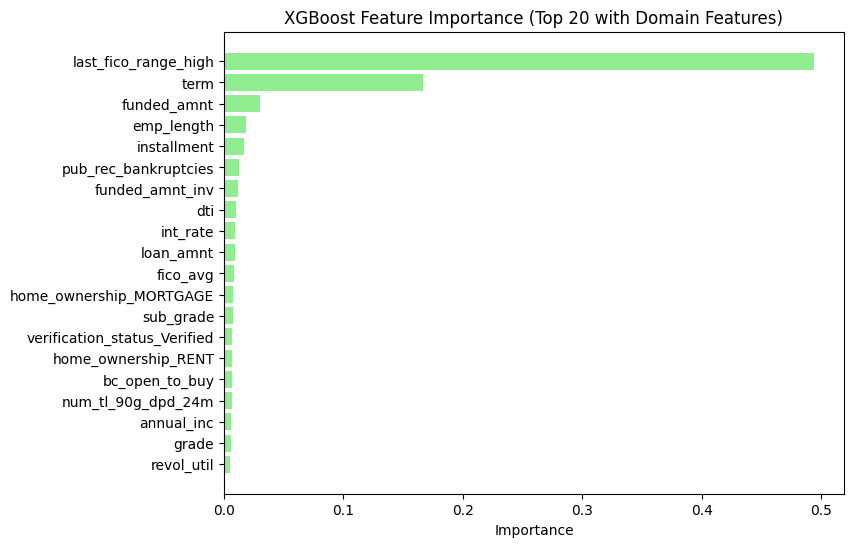

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb

# --- Feature Importance 분석 ---
# 5. XGBoost Classifier 생성 및 학습
model = XGBClassifier(random_state=42, eval_metric='mlogloss')
model.fit(X_train, y_train)

# feature importance 추출
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 반드시 포함해야 하는 도메인 feature
domain_features = ['emp_length', 'dti', 'revol_util', 'fico_avg']

# 도메인 feature 중, 데이터에 존재하는 것들을 selected에 추가
selected_features = [feat for feat in domain_features if feat in xgb_importance_df['Feature'].values]

# 전체 중요도 순으로 반복하면서, 아직 선택되지 않은 feature들을 채워나감
for feat in xgb_importance_df['Feature']:
    if feat not in selected_features:
        selected_features.append(feat)
    if len(selected_features) >= 20:
        break

# 도메인 feature가 반드시 포함되도록 최종 20개 선택
if len(selected_features) > 20:
    non_domain = [feat for feat in selected_features if feat not in domain_features]
    df_selected = xgb_importance_df[xgb_importance_df['Feature'].isin(domain_features + non_domain)]
    final_features = list(domain_features)
    for feat in df_selected['Feature']:
        if feat not in final_features:
            final_features.append(feat)
        if len(final_features) >= 20:
            break
    selected_features = final_features

print("최종 선택된 Top 20 Features:", selected_features)

# 선택된 feature에 해당하는 데이터프레임 생성 (중요도 순으로)
df_top20 = xgb_importance_df[xgb_importance_df['Feature'].isin(selected_features)]
df_top20 = df_top20.sort_values(by='Importance', ascending=False)

# --- Feature Importance 시각화 ---
def plot_feature_importance(df, title, color='skyblue'):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(df_top20, "XGBoost Feature Importance (Top 20 with Domain Features)", 'lightgreen')


In [21]:
import xgboost as xgb
import numpy as np
import os
import joblib
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

RANDOM_SEED = 42

# 이미 정의된 X_train, X_valid, X_test, y_train, y_valid, y_test 사용

# 1. DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': RANDOM_SEED
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# 2. 모델 학습 (early stopping: validation logloss 기준 10 라운드 개선 없으면 중단)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=True
)

# 3. Test 셋에서 F1-score 기준 임계치 튜닝
y_pred_prob = model.predict(dtest)

thresholds = np.linspace(0, 1, 101)
best_threshold = 0.5
best_f1 = 0.0

for t in thresholds:
    y_pred_temp = (y_pred_prob >= t).astype(int)
    current_f1 = f1_score(y_test, y_pred_temp)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = t

print(f"Best threshold based on F1: {best_threshold:.2f}, F1 score: {best_f1:.4f}")

# 4. 최적 임계치를 사용하여 최종 예측
y_pred_final = (y_pred_prob >= best_threshold).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_final))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))
print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_final)))

# 5. 모델과 최적 임계치 저장 (모델과 threshold를 딕셔너리로 묶어서 저장)
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join(model_dir, "loan_status_prop.pkl")

saved_obj = {
    "model": model,
    "best_threshold": best_threshold
}
joblib.dump(saved_obj, save_path)
print(f"Model and threshold saved to {save_path}")


[0]	train-logloss:0.37508	valid-logloss:0.37526
[1]	train-logloss:0.32204	valid-logloss:0.32234
[2]	train-logloss:0.29052	valid-logloss:0.29093
[3]	train-logloss:0.27055	valid-logloss:0.27102
[4]	train-logloss:0.25739	valid-logloss:0.25800
[5]	train-logloss:0.24855	valid-logloss:0.24929
[6]	train-logloss:0.24256	valid-logloss:0.24348
[7]	train-logloss:0.23853	valid-logloss:0.23959
[8]	train-logloss:0.23561	valid-logloss:0.23686
[9]	train-logloss:0.23359	valid-logloss:0.23497
[10]	train-logloss:0.23197	valid-logloss:0.23357
[11]	train-logloss:0.23076	valid-logloss:0.23257
[12]	train-logloss:0.22980	valid-logloss:0.23182
[13]	train-logloss:0.22905	valid-logloss:0.23129
[14]	train-logloss:0.22849	valid-logloss:0.23093
[15]	train-logloss:0.22789	valid-logloss:0.23057
[16]	train-logloss:0.22740	valid-logloss:0.23028
[17]	train-logloss:0.22694	valid-logloss:0.23010
[18]	train-logloss:0.22659	valid-logloss:0.22993
[19]	train-logloss:0.22617	valid-logloss:0.22965
[20]	train-logloss:0.22585	val

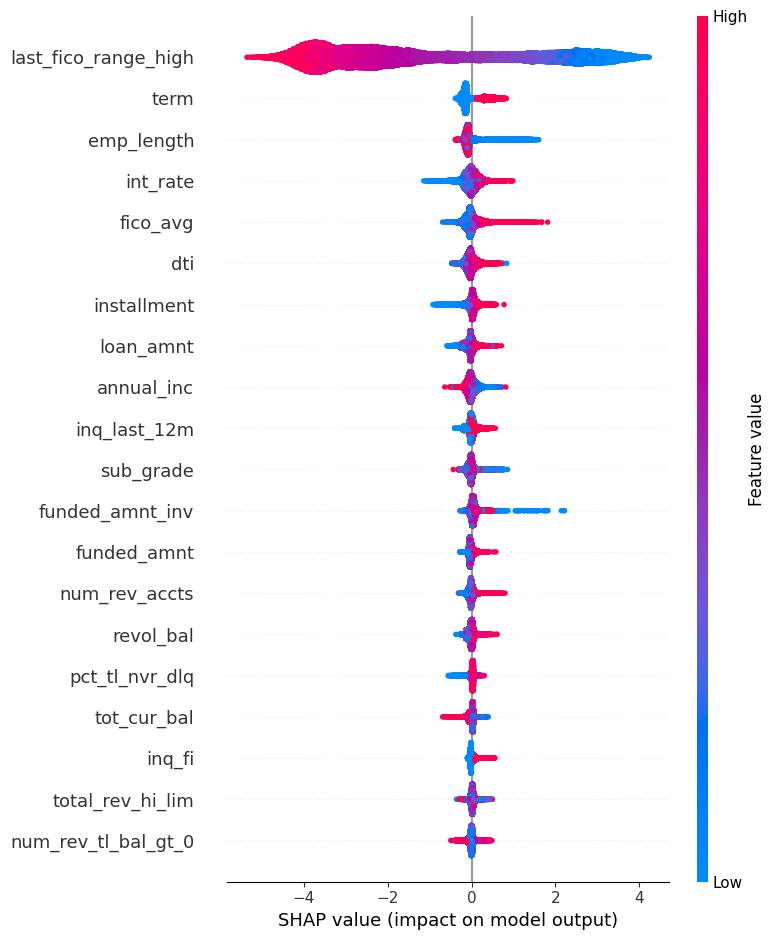

In [14]:
import shap

# TreeExplainer 생성 (XGBoost 모델에 특화됨)
explainer = shap.TreeExplainer(model)

# 테스트 데이터에 대해 SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP summary plot 생성
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
